In [312]:
import pandas as pd
import numpy as np
import random

In [313]:
users = pd.DataFrame(
    columns=[
        "id",
        "createdAt",
        "birthDate",
        "age",
        "ageGroup",
        "address",
        "city",
        "state",
        "country",
        "firstAccountType",
        "lastLoginDate",
    ]
)

accounts = pd.DataFrame(
    columns=[
        "id",
        "createdAt",
        "accountType",
        "balance",
        "status",
        "userId",
        "lastActivityDate",
        "lastTransferDate",
    ]
)

transfers = pd.DataFrame(
    columns=[
        "id",
        "amount",
        "accountType",
        "minute",
        "hour",
        "date",
        "createdAt",
        "scheduled",
        "status",
        "fromId",
        "toId",
    ]
)

# Mocando dados

In [314]:
from datetime import datetime, timedelta
from scipy.stats import skewnorm
from matplotlib import pyplot as plt

rng = np.random.default_rng()

USER_COUNT = 10000
ACCOUNT_COUNT = 30000
TRANSFER_COUNT = 100000

## users

### id

In [315]:
users["id"] = np.arange(1, USER_COUNT + 1)

### address

In [316]:
cidades_brasil = pd.read_csv(
    "./ibge_cidades.csv",
    sep=",",
    encoding="utf-8",
)

cidades_brasil.head()

cidades_brasil.drop(
    columns=["ConcatUF+Mun", "IBGE", "IBGE7", "Unnamed: 9"], inplace=True
)

cidades_brasil = cidades_brasil[cidades_brasil["População 2010"].isnull() == False]

populacao_total = cidades_brasil["População 2010"].sum()
cidades_brasil["Porcentagem da População"] = (
    cidades_brasil["População 2010"] / populacao_total
)

In [317]:
weights = cidades_brasil["Porcentagem da População"].values
weights = weights / np.sum(weights)
cidades_brasil["weights"] = weights
cidades_brasil["weights"] = cidades_brasil["weights"].apply(lambda x: float(x))

In [318]:
city_state = rng.choice(cidades_brasil[['Município', 'UF']], size=USER_COUNT, p=cidades_brasil['weights'].values)
city_state = pd.DataFrame(city_state, columns=['city', 'state'])

In [319]:
users['state'] = city_state['state']
users['city'] = city_state['city']
users['address'] = users['city'] + ', ' + users['state'] + ', Brasil'
users['country'] = 'Brasil'

### createdAt

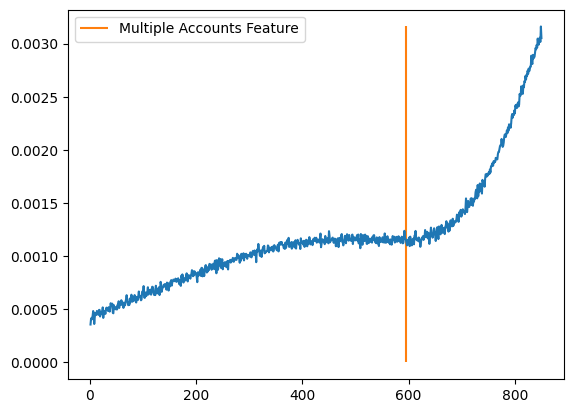

In [320]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
first_day = 1
last_day = end - start
last_day = last_day.days
lin_range = np.linspace(0, 1, last_day - first_day + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando as distribuições de pesos
weights1 = skewnorm.pdf(x=lin_range,
                        a=a1,
                        loc=loc1,
                        scale=scale1)
weights2 = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)
weights = weights1 + weights2

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = ((last_day + 1) * 0.7)

plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

In [321]:
created_at = rng.choice(np.linspace(1, last_day, last_day - first_day + 1), size=USER_COUNT, p=weights
)
users['createdAt'] = created_at
users['createdAt'] = users['createdAt'].apply(lambda x: start + timedelta(days=x))

### birthdate

Pico de usuários nascidos na faixa de 2000 a 2004


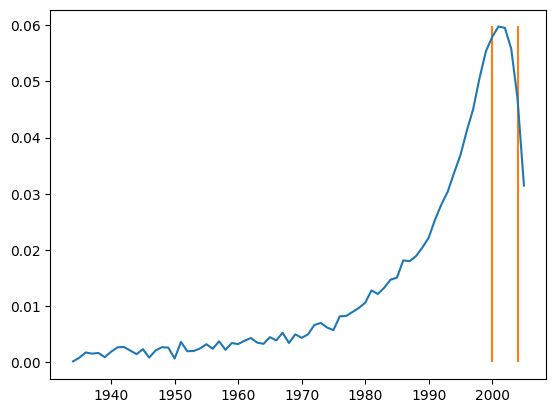

In [322]:
from scipy.stats import alpha

# Gerando range de anos
start_year = 1934
end_year = 2005
lin_range = np.linspace(0, 1, end_year - start_year + 1)


# Gerando pesos para os anos
a = 1
loc = -0.1
scale = 0.3
weights = alpha.pdf(x=lin_range, a=1, loc=loc, scale=scale)
weights = np.flip(weights)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=end_year - start_year + 1))
weights = weights / np.sum(weights)

print('Pico de usuários nascidos na faixa de 2000 a 2004')

plt.gca().vlines(np.array([2000, 2004]), ymin=0, ymax=np.max(weights), colors='C1')
plt.plot(np.arange(start_year, end_year + 1), weights)
plt.show()

In [323]:
def gen_random_date(year):
    day = random.randint(1, 31)
    month = random.randint(1, 12)
    if month == 2 and day > 28:
        day = 28
    if month in [4, 6, 9, 11] and day > 30:
        day = 30
    if month == 2 and day == 29:
        if year % 4 != 0 or (year % 100 == 0 and year % 400 != 0):
            day = 28
    birth_date = pd.Timestamp(
        year=year, month=month, day=day, hour=0, minute=0, second=0
    )
    return birth_date 

In [324]:
users["birthDate"] = rng.choice(
    np.arange(start_year, end_year + 1), size=USER_COUNT, p=weights
)

users["birthDate"] = users["birthDate"].apply(gen_random_date)

In [325]:
users["age"] = (end - users["birthDate"]).dt.days // 365

In [326]:
age_groups = [
    {"name": "18-24", "min": 18, "max": 24},
    {"name": "25-31", "min": 25, "max": 31},
    {"name": "32-48", "min": 32, "max": 38},
    {"name": "39-45", "min": 39, "max": 45},
    {"name": "46-52", "min": 46, "max": 52},
    {"name": "53-59", "min": 53, "max": 59},
    {"name": "60-66", "min": 60, "max": 66},
    {"name": "67-73", "min": 67, "max": 73},
    {"name": "74-80", "min": 74, "max": 80},
    {"name": "81+", "min": 81, "max": 100},
]

get_age_group = lambda x: [
    group["name"] for group in age_groups if group["min"] <= x <= group["max"]
]

users["ageGroup"] = users["age"].apply(lambda x: get_age_group(x)[0])

### firstAccountType

In [327]:
account_types = ['Conta Corrente', 'Conta Poupança']
users['firstAccountType'] = rng.choice(account_types, size=USER_COUNT, p=[0.67, 0.33])

### lastLoginDate

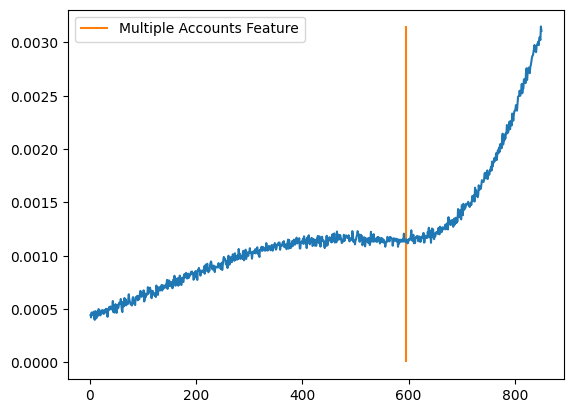

In [328]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
first_day = 1
last_day = end - start
last_day = last_day.days
lin_range = np.linspace(0, 1, last_day - first_day + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando as distribuições de pesos
weights1 = skewnorm.pdf(x=lin_range,
                        a=a1,
                        loc=loc1,
                        scale=scale1)
weights2 = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)
weights = weights1 + weights2

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = ((last_day + 1) * 0.7)

plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()